In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

import nearest_neighbors
import util

In [2]:
SENTENCES_PATH = "data/stimuli_384sentences.txt"
ENCODINGS = ["MNLI", "QQP", "SST", "SQuAD"]

In [3]:
sentences = util.load_sentences(SENTENCES_PATH)
steps = list(range(50, 5050, 50))

In [47]:
import scipy.io
brain_encoding_p01 = scipy.io.loadmat("data/P01/examples_384sentences.mat")["examples"]

In [48]:
dists, dist_stats = {}, []
for encoding_name in ENCODINGS:
    print(encoding_name)
    for step in steps:
        encoding = np.load("encodings/384sentences.bert.base.finetune-5000-%s-%i.npy" % (encoding_name, step))
        dists_e, dist_mean, dist_std = nearest_neighbors.eval_quant(encoding)
        if step == steps[-1]:
            dists[encoding_name] = dists_e

        dist_stats.append((encoding_name, step, dist_mean, dist_std))

# Also add distance data for P01 brain.
dists_b, dist_mean, dist_std = nearest_neighbors.eval_quant(brain_encoding_p01)
dists["P01"] = dists_b
dist_stats.append(("P01", 0, dist_mean, dist_std))
        
# Also add distance data for base model.
encoding = np.load("encodings/384sentences.bert.base.npy")
dists_e, dist_mean, dist_std = nearest_neighbors.eval_quant(encoding)
dists["LM"] = dists_e
dist_stats.append(("LM", 0, dist_mean, dist_std))
        
df = pd.DataFrame(dist_stats, columns=["encoding", "step", "avg_dist", "std_dist"]).set_index(["encoding", "step"])
df

MNLI
QQP
SST
SQuAD


avg_dist  std_dist
encoding step                    
MNLI     50    0.392570  0.067182
         100   0.382791  0.065619
         150   0.370495  0.063231
         200   0.368376  0.060999
         250   0.343881  0.058090
         300   0.354488  0.059479
         350   0.356976  0.058258
         400   0.353796  0.057504
         450   0.338698  0.055825
         500   0.345636  0.057745
         550   0.341889  0.056690
         600   0.351648  0.058649
         650   0.326566  0.054730
         700   0.340572  0.057131
         750   0.358004  0.060456
         800   0.333099  0.058290
         850   0.332602  0.055143
         900   0.355921  0.058751
         950   0.352728  0.059604
         1000  0.355907  0.059957
         1050  0.333962  0.059694
         1100  0.323307  0.057982
         1150  0.328922  0.057732
         1200  0.331985  0.059356
         1250  0.327832  0.058369
         1300  0.318609  0.056538
         1350  0.343930  0.061485
         1400  0.352430  0.062731
         1450  0.348688  0.062901
         1500  0.317571  0.057338
...                 ...       ...
SQuAD    3650  0.181195  0.041326
         3700  0.179198  0.040604
         3750  0.188063  0.042374
         3800  0.177965  0.040416
         3850  0.165957  0.038140
         3900  0.168338  0.038790
         3950  0.160439  0.037517
         4000  0.160293  0.037126
         4050  0.173221  0.039928
         4100  0.178738  0.041270
         4150  0.175280  0.040624
         4200  0.175868  0.040225
         4250  0.188584  0.042170
         4300  0.186855  0.041770
         4350  0.183696  0.041329
         4400  0.179820  0.040579
         4450  0.180194  0.040940
         4500  0.182371  0.041225
         4550  0.185732  0.042153
         4600  0.188582  0.042428
         4650  0.183967  0.042032
         4700  0.180244  0.041475
         4750  0.179154  0.041186
         4800  0.178982  0.041165
         4850  0.182204  0.041646
         4900  0.182231  0.041670
         4950  0.181361  0.041548
         5000  0.181098  0.041509
P01      0     0.710002  0.191602
LM       0     0.399435  0.068384

[402 rows x 2 columns]

## Pairwise distance: global metrics

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


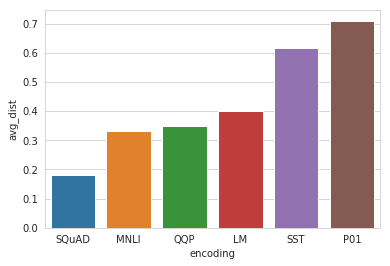

In [49]:
final_dists = df.xs(5000, level="step")
final_dists.loc["LM"] = df.loc["LM", 0]
final_dists.loc["P01"] = df.loc["P01", 0]
order = final_dists.avg_dist.argsort()
sns.barplot(data=final_dists.reset_index(), x="encoding", y="avg_dist", order=order.index[order])

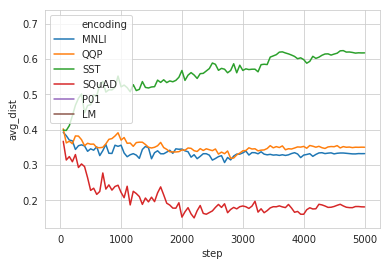

In [50]:
sns.lineplot(data=df.reset_index(), x="step", hue="encoding", y="avg_dist")

## Pairwise distance: local evaluation

In [7]:
def argsmallest_n(a, n):
    ret = np.argpartition(a, n)[:n]
    b = np.take(a, ret)
    return np.take(ret, np.argsort(b))

In [8]:
tu = np.triu_indices(np.ceil(np.sqrt(2 * len(next(iter(dists.values()))))), 1)
def nearest_neighbor_sentences(encoding_name, n=10):
    closest = argsmallest_n(dists[encoding_name], n)
    pairs = np.column_stack((np.take(tu[0], closest),
                             np.take(tu[1], closest))) + 1
    
    ret = []
    for (s1_id, s2_id), dist_id in zip(pairs, closest):
        ret.append((dists[encoding_name][dist_id], sentences[s1_id], sentences[s2_id]))
        
    return ret

In [51]:
nearest_neighbor_sentences("P01")

[(0.15887810697275728,
  'A luthier is a carpenter that makes and repairs musical instruments.',
  'Depending on the size and format, scissors can cut paper, hair or fabric.'),
 (0.1898008496921858,
  'A desert is a natural environment where almost no rain falls.',
  'The blades are usually metallic, with plastic or metal handles.'),
 (0.1939582940944079,
  'A desert is a natural environment where almost no rain falls.',
  "Theft is the taking of person's property without their consent."),
 (0.2072922761439785,
  'Fingers are used for grasping, writing, grooming and other activities.',
  'The nail protects the tip of the finger and can be grown or decorated.'),
 (0.20966142667205867,
  'A ship can be powered in the ocean by sails, steam, or diesel engines.',
  "Theft is the taking of person's property without their consent."),
 (0.21007675900551082,
  'Forks are usually  made of metal, or plastic, if disposable.',
  'The blades are usually metallic, with plastic or metal handles.'),
 (

In [42]:
nearest_neighbor_sentences("LM")

[(0.039947988410841684,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.07919518413224313,
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.',
  'There are many varieties of tomato, with different sizes and tastes.'),
 (0.08327981648077065,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.0852415866176992,
  'Chairs consist of a seat raised above floor level, supported by legs.',
  'There are usually chairs around a table for people to sit.'),
 (0.08708882924719685,
  'Arson is the criminal act of burning a building or wildland.',
  'A butterfly is a flying insect with four large wings.'),
 (0.09261169883460807,
  'The axe usually consists of a head attached to a handle.',
  'Modern knives consist of a handle and a blade, usually made of metal.'),
 (0.09383378004750353,
  'A butterfly is a flying 

In [9]:
nearest_neighbor_sentences("MNLI")

[(0.02490522491028424,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.07703453636887947,
  'A tropical cyclone can move inland and seriously damage property.',
  'The violin is an instrument with four strings that is played with a bow.'),
 (0.07705547893459674,
  'The term is used to indicate sex distinctions relative to girls.',
  'At puberty the body of a girl develops into that of a woman.'),
 (0.08913282215670404,
  'Arson is the criminal act of burning a building or wildland.',
  'A butterfly is a flying insect with four large wings.'),
 (0.08976477742005962,
  'Arson is the criminal act of burning a building or wildland.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.09167105755975224,
  'Girls often like playing with dolls and social games.',
  'Manhood is associated with masculinity and virility.'),
 (0.09911678248505784,
  'Female mosquitoes bite people and animals and 

In [10]:
nearest_neighbor_sentences("QQP")

[(0.06986917401497872,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.0767816159569008,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.08168490083280255,
  'Female mosquitoes bite people and animals and suck their blood for protein.',
  'Mosquito bites can spread yellow fever, malaria and other parasite diseases.'),
 (0.090916283892996,
  'Chairs consist of a seat raised above floor level, supported by legs.',
  'There are usually chairs around a table for people to sit.'),
 (0.09643503108258644,
  'Screwdrivers can also be used to remove screws after they are inserted.',
  'The screwdriver tip applies the torque from rotating the handle.'),
 (0.09893376799977383,
  'The axe usually consists of a head attached to a handle.',
  'Modern knives consist of a handle and a blade, usually made of metal.'),
 (0.09894271151293099,
 

In [11]:
nearest_neighbor_sentences("SQuAD")

[(0.027955744543422534,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.038175930294760296,
  'Blenders are also used to make cold alcoholic drinks with crushed ice.',
  'A boy is a young male child who has not undergone puberty.'),
 (0.03862464317906833,
  'Arson is the criminal act of burning a building or wildland.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.041123831770839114,
  'In folklore ravens are birds of ill-omen and also tricksters.',
  'A ship is a large vehicle that floats and travels on water.'),
 (0.041201944974636806,
  'A butterfly is a flying insect with four large wings.',
  'Lettuce is considered fairly easy to grow and a suitable crop for beginners.'),
 (0.043137451369787416,
  'A desk may have drawers to store supplies and papers.',
  'A mug is thick and has a ring base for thermal insulation.'),
 (0.04415510612111706,
  'Arson is the criminal act of bur

In [12]:
nearest_neighbor_sentences("SST")

[(0.03855845676004732,
  'Salmon can be eaten raw in sushi or cooked by grilling, poaching or in other ways.',
  'A tomato softens and changes color from green to red as it gets more ripe.'),
 (0.04398814033337217,
  'A boy becomes a man after passing through puberty.',
  'A woman is stereotypically seen as a caregiver.'),
 (0.04527948468843801,
  'Metamorphosis is the transformation of a caterpillar into a butterfly.',
  'A carpenter is an artist or manual laborer who works with wood.'),
 (0.05460931936005886,
  'Extreme drought will eventually turn areas into desert and cause famine.',
  'Large numbers of people have to migrate away from dust bowls.'),
 (0.05945807218331456,
  'Metamorphosis is the transformation of a caterpillar into a butterfly.',
  'A peach is an orange-yellow fruit with a characteristic smell.'),
 (0.06802162734929784,
  'Parrots have brightly-colored feathers and a sharp, curved beak.',
  'Ravens feed on carrion, insects, berries or small animals.'),
 (0.0696310

## Rank change analysis

In [13]:
encoding_preds = {}
for encoding in ENCODINGS:
    for step in steps:
        encoding_preds[(encoding, step)] = pd.read_csv("perf.384sentences.bert.base.finetune-5000-%s-%i.pred.csv" % (encoding, step),
                                                       index_col=[0, 1])
    
encoding_preds = pd.concat(encoding_preds, names=["model", "step"])
encoding_preds.head()

rank
model step subject idx      
MNLI  50   P01     0       8
                   1      36
                   2      34
                   3      49
                   4      12

In [14]:
rank_changes = encoding_preds.reset_index().set_index(["step", "idx"]) \
    .groupby("model").apply(lambda model_preds: model_preds.groupby("idx").apply(
        lambda preds: (preds.loc[steps[-1]]["rank"] - preds.loc[steps[0]]["rank"]).mean()))
rank_changes

idx,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
model,,,,,,,,,,,,,,,,,,,,,
MNLI,39.875,6.750,-15.000,2.50,17.125,-2.625,-0.875,-8.250,27.25,-3.375,...,17.000,18.250,38.500,0.875,39.250,26.500,9.250,58.75,23.250,9.500
QQP,9.250,-25.500,-15.500,-29.75,-6.250,-5.750,-12.750,-0.375,5.00,0.000,...,-3.750,30.125,12.125,24.125,3.625,2.375,5.000,18.00,-14.000,-5.125
SQuAD,47.000,12.875,22.500,11.50,30.625,-12.125,1.375,1.000,10.75,3.750,...,-43.875,6.500,24.750,-1.000,9.125,27.875,13.875,40.25,1.250,7.125
SST,38.125,30.125,110.875,124.50,-1.375,31.875,52.500,37.875,51.00,55.250,...,-23.750,23.375,5.750,51.000,43.250,-0.250,12.250,54.25,67.875,120.000


In [15]:
# Change from wide to long format.
rank_changes = pd.melt(rank_changes.reset_index(), id_vars=["model"], value_name="rank_change") \
    .set_index(["model", "idx"])
rank_changes.head()

,,rank_change
model,idx,
MNLI,0,39.875
QQP,0,9.250
SQuAD,0,47.000
SST,0,38.125
MNLI,1,6.750


Text(0.5,1,'Average sentence rank change')

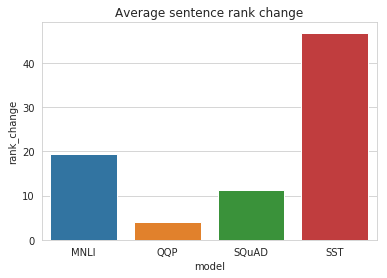

In [16]:
sns.barplot(data=rank_changes.mean(level=0).reset_index(), x="model", y="rank_change")
plt.title("Average sentence rank change")

In [17]:
n = 10

for model, rank_changes_m in rank_changes.reset_index().groupby("model"):
    print("\n\n========\n" + model)
    
    rank_changes_m = rank_changes_m.set_index("idx")
    top_sentences = rank_changes_m.index[rank_changes_m.rank_change.argsort()[::-1]]
    for sent_id in top_sentences[:n]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])
    print()
    for sent_id in top_sentences[-n:][::-1]:
        print(rank_changes_m.loc[sent_id].rank_change, sentences[sent_id])



MNLI
172.875 The wings of butterflies can be very colorful and patterned.
129.75 A forest is an area with a high density of trees and canopy cover.
117.25 The nail protects the tip of the finger and can be grown or decorated.
112.0 Another type of bed is the hammock, a fabric sling suspended above the ground.
109.75 A refrigerator is a cooling device used to contain and preserve food.
92.625 Other types of doors can slide or consist of a revolving chamber.
92.25 Piranhas have very sharp teeth and are opportunistic carnivores.
90.375 A forest ecosystem has various types of trees and animals, as well as ground plants.
85.75 In waterbeds the mattress is filled with water, and in airbeds it is filled with air.
77.5 The type of forest depends on temperature and rainfall in its location.

-69.75 The wheels have rubber tires with an inner tube full of air.
-57.125 Mosquitoes have mouthparts for piercing the skin of plants and animals.
-46.375 A ship can be powered in the ocean by sails, ste